#**Problem Statement**

This problem statement is based on the Shinkansen Bullet Train in Japan, and passengers’ experience with that mode of travel. This machine-learning exercise aims to determine the relative importance of each parameter with regard to their contribution to the passengers’ overall travel experience. The dataset contains a random sample of individuals who traveled on this train. The on-time performance of the trains along with passenger information is published in a file named ‘Traveldata_train.csv’.  These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report labeled ‘Surveydata_train.csv’.

In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in the data of the survey report under the variable labeled ‘Overall_Experience’.

The objective of this problem is to understand which parameters play an important role in swaying passenger feedback towards a positive scale. You are provided test data containing the travel data and the survey data of passengers. Both the test data and the train data are collected at the same time and belong to the same population.

#**Imports**

In [1]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
# set the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from sklearn.ensemble import RandomForestClassifier

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To check model performance
from sklearn.metrics import (
    auc,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    roc_curve,
    make_scorer
)

# used for stats functions like zscore
from scipy import stats
from scipy.stats import uniform

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Accuracy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

import xgboost as xgb
from xgboost import XGBClassifier

from scikeras.wrappers import KerasClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from datetime import datetime

#**Read Datasets**

In [3]:
# Read the datasets
traveldata_train = pd.read_csv("/content/Traveldata_train_(2).csv")
surveydata_train = pd.read_csv("/content/Surveydata_train_(2).csv")
traveldata_test = pd.read_csv("/content/Traveldata_test_(2).csv")
surveydata_test = pd.read_csv("/content/Surveydata_test_(2).csv")

#**Data Description**

In [4]:
def categorical_value_percentage(df):
  # Select only the categorical columns
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns

  # Iterate through each categorical column
  for col in categorical_columns:
    # Calculate the value counts and percentage for each category
    print(df[col].value_counts(1))
    print("-" * 50)

In [5]:
def id_value_count(df):
  # Step 1: Count the occurrences of each unique value in the 'ID' column
  counts = df['ID'].value_counts()

  # Step 2: Filter the counts to find values with more than one occurrence
  duplicate_ids = counts[counts > 1]
  print(f"Non unique values: {duplicate_ids.index.tolist()}")

##**Travel Data Description**

In [6]:
traveldata_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.00000,NaN,Business,272,0.00000,5.00000
1,98800002,Male,Loyal Customer,48.00000,Personal Travel,Eco,2200,9.00000,0.00000
2,98800003,Female,Loyal Customer,43.00000,Business Travel,Business,1061,77.00000,119.00000
3,98800004,Female,Loyal Customer,44.00000,Business Travel,Business,780,13.00000,18.00000
4,98800005,Female,Loyal Customer,50.00000,Business Travel,Business,1981,0.00000,0.00000


In [7]:
traveldata_test.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,99900001,Female,NaN,36.00000,Business Travel,Business,532,0.00000,0.00000
1,99900002,Female,Disloyal Customer,21.00000,Business Travel,Business,1425,9.00000,28.00000
2,99900003,Male,Loyal Customer,60.00000,Business Travel,Business,2832,0.00000,0.00000
3,99900004,Female,Loyal Customer,29.00000,Personal Travel,Eco,1352,0.00000,0.00000
4,99900005,Male,Disloyal Customer,18.00000,Business Travel,Business,1610,17.00000,0.00000


In [8]:
traveldata_train.shape

(94379, 9)

In [9]:
traveldata_test.shape

(35602, 9)

In [10]:
traveldata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [11]:
traveldata_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Gender                   35572 non-null  object 
 2   Customer_Type            32219 non-null  object 
 3   Age                      35591 non-null  float64
 4   Type_Travel              32154 non-null  object 
 5   Travel_Class             35602 non-null  object 
 6   Travel_Distance          35602 non-null  int64  
 7   Departure_Delay_in_Mins  35573 non-null  float64
 8   Arrival_Delay_in_Mins    35479 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.4+ MB


In [12]:
traveldata_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.00000,98847190.00000,27245.01487,98800001.00000,98823595.50000,98847190.00000,98870784.50000,98894379.00000
Age,94346.00000,39.41965,15.11663,7.00000,27.00000,40.00000,51.00000,85.00000
Travel_Distance,94379.00000,1978.88818,1027.96102,50.00000,1359.00000,1923.00000,2538.00000,6951.00000
Departure_Delay_in_Mins,94322.00000,14.64709,38.13878,0.00000,0.00000,0.00000,12.00000,1592.00000
Arrival_Delay_in_Mins,94022.00000,15.00522,38.43941,0.00000,0.00000,0.00000,13.00000,1584.00000


In [13]:
traveldata_test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,35602.00000,99917801.50000,10277.55648,99900001.00000,99908901.25000,99917801.50000,99926701.75000,99935602.00000
Age,35591.00000,39.44700,15.13755,7.00000,27.00000,40.00000,51.00000,85.00000
Travel_Distance,35602.00000,1987.15176,1024.30886,50.00000,1360.00000,1929.00000,2559.00000,6868.00000
Departure_Delay_in_Mins,35573.00000,14.88070,37.89545,0.00000,0.00000,0.00000,13.00000,978.00000
Arrival_Delay_in_Mins,35479.00000,15.30880,38.53129,0.00000,0.00000,0.00000,13.00000,970.00000


In [14]:
traveldata_train.isnull().sum()

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64

In [15]:
traveldata_test.isnull().sum()

ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64

In [16]:
traveldata_train.duplicated().sum()

0

In [17]:
traveldata_test.duplicated().sum()

0

In [18]:
categorical_value_percentage(traveldata_train)

Gender
Female   0.50704
Male     0.49296
Name: proportion, dtype: float64
--------------------------------------------------
Customer_Type
Loyal Customer      0.81733
Disloyal Customer   0.18267
Name: proportion, dtype: float64
--------------------------------------------------
Type_Travel
Business Travel   0.68837
Personal Travel   0.31163
Name: proportion, dtype: float64
--------------------------------------------------
Travel_Class
Eco        0.52281
Business   0.47719
Name: proportion, dtype: float64
--------------------------------------------------


In [19]:
categorical_value_percentage(traveldata_test)

Gender
Female   0.50796
Male     0.49204
Name: proportion, dtype: float64
--------------------------------------------------
Customer_Type
Loyal Customer      0.81781
Disloyal Customer   0.18219
Name: proportion, dtype: float64
--------------------------------------------------
Type_Travel
Business Travel   0.69394
Personal Travel   0.30606
Name: proportion, dtype: float64
--------------------------------------------------
Travel_Class
Eco        0.51888
Business   0.48112
Name: proportion, dtype: float64
--------------------------------------------------


In [20]:
id_value_count(traveldata_train)

Non unique values: []


In [21]:
id_value_count(traveldata_test)

Non unique values: []


##**Survey Data Description**

In [22]:
surveydata_train.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [23]:
surveydata_test.head()

,ID,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Extremely Poor,Ordinary,Good,Poor,Manageable,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Acceptable,Green Car,Excellent,Acceptable,Very Convenient,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Excellent,Ordinary,Extremely Poor,Excellent,Needs Improvement,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent


In [24]:
surveydata_train.shape

(94379, 17)

In [25]:
surveydata_test.shape

(35602, 16)

In [26]:
surveydata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [27]:
surveydata_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       35602 non-null  int64 
 1   Seat_Comfort             35580 non-null  object
 2   Seat_Class               35602 non-null  object
 3   Arrival_Time_Convenient  32277 non-null  object
 4   Catering                 32245 non-null  object
 5   Platform_Location        35590 non-null  object
 6   Onboard_Wifi_Service     35590 non-null  object
 7   Onboard_Entertainment    35594 non-null  object
 8   Online_Support           35576 non-null  object
 9   Ease_of_Online_Booking   35584 non-null  object
 10  Onboard_Service          32730 non-null  object
 11  Legroom                  35577 non-null  object
 12  Baggage_Handling         35562 non-null  object
 13  CheckIn_Service          35580 non-null  object
 14  Cleanliness              35600 non-nul

In [28]:
surveydata_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.00000,98847190.00000,27245.01487,98800001.00000,98823595.50000,98847190.00000,98870784.50000,98894379.00000
Overall_Experience,94379.00000,0.54666,0.49782,0.00000,0.00000,1.00000,1.00000,1.00000


In [29]:
surveydata_test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,35602.00000,99917801.50000,10277.55648,99900001.00000,99908901.25000,99917801.50000,99926701.75000,99935602.00000


In [30]:
surveydata_train.isnull().sum()

ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

In [31]:
surveydata_test.isnull().sum()

ID                            0
Seat_Comfort                 22
Seat_Class                    0
Arrival_Time_Convenient    3325
Catering                   3357
Platform_Location            12
Onboard_Wifi_Service         12
Onboard_Entertainment         8
Online_Support               26
Ease_of_Online_Booking       18
Onboard_Service            2872
Legroom                      25
Baggage_Handling             40
CheckIn_Service              22
Cleanliness                   2
Online_Boarding               2
dtype: int64

In [32]:
surveydata_train.duplicated().sum()

0

In [33]:
surveydata_test.duplicated().sum()

0

In [34]:
categorical_value_percentage(surveydata_train)

Seat_Comfort
Acceptable          0.22433
Needs Improvement   0.22208
Good                0.21836
Poor                0.16100
Excellent           0.13752
Extremely Poor      0.03672
Name: proportion, dtype: float64
--------------------------------------------------
Seat_Class
Green Car   0.50260
Ordinary    0.49740
Name: proportion, dtype: float64
--------------------------------------------------
Arrival_Time_Convenient
Good                0.22907
Excellent           0.20695
Acceptable          0.17761
Needs Improvement   0.17543
Poor                0.16024
Extremely Poor      0.05070
Name: proportion, dtype: float64
--------------------------------------------------
Catering
Acceptable          0.21565
Needs Improvement   0.20993
Good                0.20983
Poor                0.16182
Excellent           0.15711
Extremely Poor      0.04566
Name: proportion, dtype: float64
--------------------------------------------------
Platform_Location
Manageable          0.25621
Convenient       

In [35]:
categorical_value_percentage(surveydata_test)

Seat_Comfort
Acceptable          0.22493
Needs Improvement   0.22010
Good                0.21945
Poor                0.16175
Excellent           0.13642
Extremely Poor      0.03735
Name: proportion, dtype: float64
--------------------------------------------------
Seat_Class
Ordinary    0.50166
Green Car   0.49834
Name: proportion, dtype: float64
--------------------------------------------------
Arrival_Time_Convenient
Good                0.22806
Excellent           0.20414
Acceptable          0.18106
Needs Improvement   0.17610
Poor                0.15897
Extremely Poor      0.05168
Name: proportion, dtype: float64
--------------------------------------------------
Catering
Acceptable          0.22121
Needs Improvement   0.20782
Good                0.20782
Poor                0.16058
Excellent           0.15584
Extremely Poor      0.04674
Name: proportion, dtype: float64
--------------------------------------------------
Platform_Location
Manageable          0.26311
Convenient       

In [36]:
id_value_count(surveydata_train)

Non unique values: []


In [37]:
id_value_count(surveydata_test)

Non unique values: []


#**Perform Data Preprocessing**

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierRemover(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=3.0):
    self.threshold = threshold

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # Compute z-scores
    z_scores = np.abs((X - np.mean(X, axis=0)) / np.std(X, axis=0))
    # Keep only rows where all z-scores are below the threshold
    mask = (z_scores < self.threshold).all(axis=1)
    return X[mask]

class DropMissingValues(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=0.5):
    self.threshold = threshold

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # Calculate the threshold for dropping rows
    missing_threshold = int(self.threshold * X.shape[1])
    # Drop rows where the number of missing values exceeds the threshold
    mask = (X.isnull().sum(axis=1) <= missing_threshold)
    X_filtered = X[mask]
    return X_filtered.reset_index(drop=True)

# Custom transformer to remove specified columns
def drop_columns(X, columns_to_drop):
  return X.drop(columns=columns_to_drop, errors='ignore')

In [39]:
# Join the training data on the ID for train and test
train_data = pd.merge(traveldata_train, surveydata_train, on='ID', how='inner')
test_data = pd.merge(traveldata_test, surveydata_test, on='ID', how='inner')

# Drop the ID column since it won't be needed anymore
train_data = train_data.drop('ID', axis=1)

print(train_data.head())
print('-'*50)
print(train_data.shape)
print('-'*50)
print(train_data.info())

   Gender   Customer_Type      Age      Type_Travel Travel_Class  Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  Overall_Experience       Seat_Comfort Seat_Class Arrival_Time_Convenient           Catering  Platform_Location Onboard_Wifi_Service Onboard_Entertainment Online_Support Ease_of_Online_Booking    Onboard_Service            Legroom   Baggage_Handling    CheckIn_Service        Cleanliness Online_Boarding
0  Female  Loyal Customer 52.00000              NaN     Business              272                  0.00000                5.00000                   0  Needs Improvement  Green Car               Excellent          Excellent    Very Convenient                 Good     Needs Improvement     Acceptable      Needs Improvement  Needs Improvement         Acceptable  Needs Improvement               Good  Needs Improvement            Poor
1    Male  Loyal Customer 48.00000  Personal Travel          Eco             2200                  9.00000                0.00000   

In [40]:
# convert object columns to categorical
categorical_columns = train_data.select_dtypes(include=['object']).columns
train_data[categorical_columns] = train_data[categorical_columns].astype('category')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Gender                   94302 non-null  category
 1   Customer_Type            85428 non-null  category
 2   Age                      94346 non-null  float64 
 3   Type_Travel              85153 non-null  category
 4   Travel_Class             94379 non-null  category
 5   Travel_Distance          94379 non-null  int64   
 6   Departure_Delay_in_Mins  94322 non-null  float64 
 7   Arrival_Delay_in_Mins    94022 non-null  float64 
 8   Overall_Experience       94379 non-null  int64   
 9   Seat_Comfort             94318 non-null  category
 10  Seat_Class               94379 non-null  category
 11  Arrival_Time_Convenient  85449 non-null  category
 12  Catering                 85638 non-null  category
 13  Platform_Location        94349 non-null  category
 14  Onboar

##**Preprocessing Pipeline**

In [41]:
# Define the numerical and categorical columns
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns.difference(['Overall_Experience'])
categorical_features = train_data.select_dtypes(include=['category']).columns

# Remove any rows that have more then the threshold of missing values
dropper = DropMissingValues(threshold=0.05)
train_data_dropped = dropper.fit_transform(train_data)
print(f'Number of rows dropped: {train_data.shape[0] - train_data_dropped.shape[0]}')

# Define the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
  ])

# Create the full pipeline
pipeline = Pipeline(steps=[
  ('preprocessor', preprocessor),
])

# Drop the target column
X_train_data_dropped = train_data_dropped.drop(columns=['Overall_Experience'])
y_train_data_dropped = train_data_dropped['Overall_Experience']

# Fit the pipeline on the training data
pipeline.fit(X_train_data_dropped)

# Transform the training data
X_train_data_processed = pipeline.transform(X_train_data_dropped)
print(type(X_train_data_processed))
print(X_train_data_processed.shape)

# Convert the processed data back to dataframes
# Note: We need to get the feature names from the column transformer
numeric_feature_names = numeric_features
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Verify the shape
print(f"Expected number of features before drop: {len(all_feature_names)}")

X_train_data_processed_df = pd.DataFrame(X_train_data_processed.toarray(), columns=all_feature_names)

# drop unimportant columns
# columns_to_drop =  ['Online_Support_Extremely Poor', 'Onboard_Service_Extremely Poor', 'Cleanliness_Extremely Poor',
#    'CheckIn_Service_Extremely Poor', 'Onboard_Wifi_Service_Extremely Poor',
#    'Seat_Class_Ordinary', 'CheckIn_Service_Good', 'Onboard_Service_missing',
#    'Onboard_Wifi_Service_Needs Improvement', 'Arrival_Time_Convenient_missing',
#    'Departure_Delay_in_Mins', 'Travel_Distance', 'Onboard_Service_Good', 'Catering_Poor',
#    'Online_Support_Needs Improvement', 'Onboard_Service_Needs Improvement',
#    'Legroom_Needs Improvement', 'Legroom_Poor', 'Age',
#    'Arrival_Time_Convenient_Needs Improvement', 'Cleanliness_Needs Improvement',
#    'Arrival_Delay_in_Mins', 'Catering_missing', 'Onboard_Service_Poor',
#    'Arrival_Time_Convenient_Poor', 'Online_Support_Poor',
#    'Baggage_Handling_Needs Improvement', 'Cleanliness_Good', 'Platform_Location_Manageable',
#    'Onboard_Wifi_Service_Poor', 'Arrival_Time_Convenient_Extremely Poor']
columns_to_drop = []
X_train_data_processed_df = drop_columns(X_train_data_processed_df, columns_to_drop)

# remove the columns that were dropped
all_feature_names_dropped = [col for col in all_feature_names if col not in columns_to_drop]

# Verify the shape
print(f"Expected number of features after drop: {len(all_feature_names_dropped)}")

print(X_train_data_processed_df.head())
print('-'*50)
print(f'Shape of processed dataframe: {X_train_data_processed_df.shape}')
print('-'*50)
print(X_train_data_processed_df.info())

Number of rows dropped: 5188
<class 'scipy.sparse._csr.csr_matrix'>
(89191, 78)
Expected number of features before drop: 78
Expected number of features after drop: 78
      Age  Arrival_Delay_in_Mins  Departure_Delay_in_Mins  Travel_Distance  Gender_Male  Customer_Type_Loyal Customer  Type_Travel_Personal Travel  Travel_Class_Eco  Seat_Comfort_Excellent  Seat_Comfort_Extremely Poor  Seat_Comfort_Good  Seat_Comfort_Needs Improvement  Seat_Comfort_Poor  Seat_Class_Ordinary  Arrival_Time_Convenient_Excellent  Arrival_Time_Convenient_Extremely Poor  Arrival_Time_Convenient_Good  Arrival_Time_Convenient_Needs Improvement  Arrival_Time_Convenient_Poor  Catering_Excellent  Catering_Extremely Poor  Catering_Good  Catering_Needs Improvement  Catering_Poor  Platform_Location_Inconvenient  Platform_Location_Manageable  Platform_Location_Needs Improvement  Platform_Location_Very Convenient  Platform_Location_Very Inconvenient  Onboard_Wifi_Service_Excellent  Onboard_Wifi_Service_Extremely Poor  On

#**Model Performance Evaluation**

In [42]:
# Function to compute different metrics to check performance of the classification models
def model_performance_classification(model, x_test, y_test, y_pred, name='test'):
  """
  Function to compute different metrics to check classification model performance

  model: classifier
  x_test: independent variables
  y_test: dependent variable
  y_pred: predictions
  name: optional name of the model
  """
  accuracy = accuracy_score(y_test, y_pred)
  print(f'{name} Accuracy: {accuracy}')
  print('Classification Report:')
  print(classification_report(y_test, y_pred))

  # Generate the classification report as a dictionary
  report_dict = classification_report(y_test, y_pred, output_dict=True)

  new_report_dict = {
    'name': name,
    'precision': report_dict['1']['precision'],
    'recall': report_dict['1']['recall'],
    'f1-score': report_dict['1']['f1-score'],
    'accuracy': report_dict['accuracy']
  }

  # Convert the report to a DataFrame
  report_df = pd.DataFrame(new_report_dict, index=[0])

  cm = confusion_matrix(y_test, y_pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['Actual Negative', 'Actual Positive'])

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

  return report_df

#**Model Building**

In [43]:
# X and y from pipeline processing
X = X_train_data_processed_df
y = y_train_data_dropped

# Split the data into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the same preprocessing pipeline to the test data without dropping rows but removing columns
X_test = test_data
X_test_processed = pipeline.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed.toarray(), columns=all_feature_names)
print(f"Expected number of features before drop: {X_test_processed_df.shape[1]}")
X_test_processed_df = drop_columns(X_test_processed_df, columns_to_drop)
print(f"Expected number of features after drop: {X_test_processed_df.shape[1]}")
print(f"Expected number of features after drop: {len(all_feature_names_dropped)}")

Expected number of features before drop: 78
Expected number of features after drop: 78
Expected number of features after drop: 78


##**Random Forest Classifier**

In [ ]:
rf_classifier = RandomForestClassifier(random_state = 42)

# Grid of parameters to choose from
param_grid = {
    'n_estimators': [
        # 100,
        # 150,
        # 200,
        # 300,
        500
    ],
    'max_depth': [
        None,
        # 10,
        # 20
    ],
    'min_samples_split': [
        2,
        # 5,
        # 20
    ],
    'min_samples_leaf': [
        1,
        # 10,
        # 15
    ],
    'bootstrap': [
        # True,
        False
    ],
    'class_weight': [
        # None,
        # 'balanced',
        'balanced_subsample'
    ],
    'criterion': [
        # 'gini',
        # 'entropy',
        'log_loss'
    ]
}

start_time = datetime.now()

# Setup the gridsearch with tuning using f1 due to imbalanced target classes
rf_grid = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid,
                              scoring = 'accuracy', cv = 5, n_jobs=-1, random_state=42,
                              n_iter=1)

# train using the raw data without removing the outliers bc tree algos work fine with them
rf_grid = rf_grid.fit(X_train, y_train)

# print the best params
print(f'Best Parameters: {rf_grid.best_params_}')
print(f'Best accuracy: {rf_grid.best_score_}')

# Set the tuned_classifier to the best combination of parameters
rf_best_classifier = rf_grid.best_estimator_

# Calculate Predictions
y_pred = rf_best_classifier.predict(X_validation)

# Model Performance on the validation data
rf_best_report = model_performance_classification(rf_best_classifier, X_validation, y_validation, y_pred, 'Random Forest')

# Make predictions
y_test_pred = rf_best_classifier.predict(X_test_processed_df)

end_time = datetime.now()
print(f'Elapsed time: {end_time - start_time}')

# Output predictions into a csv
output = pd.DataFrame({'ID': test_data['ID'], 'Overall_Experience': y_test_pred})
output.to_csv('random_forest_predictions.csv', index=False)

KeyboardInterrupt: 

##**XGBoost Classifier**

Best Parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.95}
Best accuracy: 0.9564552878392565
XGBoost Accuracy: 0.9582936263243456
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      8227
           1       0.97      0.96      0.96      9612

    accuracy                           0.96     17839
   macro avg       0.96      0.96      0.96     17839
weighted avg       0.96      0.96      0.96     17839



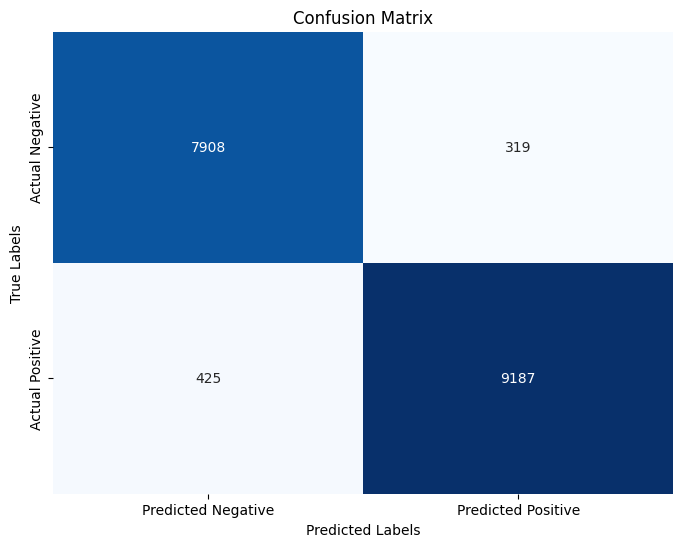

Training on full set of data with (89191, 78) number of rows
Elapsed time: 0:01:02.654125


In [44]:
# XGBoost Classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', use_label_encoder=False,
                               eval_metric='merror', random_state=42, num_class=len(np.unique(y_train)))

param_grid = {
    'n_estimators': [
        # 100,
        # 200,
        300,
        # 400,
        # 500
    ],
    'max_depth': [
        # 3,
        # 4,
        # 5,
        # 6,
        # 7,
        # 8,
        # 9,
        10,
        11
    ],
    'learning_rate': [
        # 0.01,
        # 0.05,
        0.1,
        # 0.15,
        # 0.2,
        # 0.25,
        # 0.3
    ],
    'subsample': [
        # 0.5,
        # 0.55,
        # 0.6,
        # 0.65,
        # 0.7,
        # 0.75,
        # 0.8,
        # 0.9,
        0.95,
        # 1.0
    ],
    'colsample_bytree': [
        # 0.5,
        # 0.55,
        # 0.6,
        # 0.65,
        # 0.7,
        0.75,
        # 0.8,
        # 0.9,
        # 0.95,
        # 1.0
    ],
    'min_child_weight': [
        1,
        # 2,
        # 3,
        # 4,
        # 5
    ]
}

start_time = datetime.now()

# Setup the gridsearch with tuning using f1 due to imbalanced target classes
# xgb_grid = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_grid,
#                               scoring='accuracy', cv=5, n_jobs=-1, random_state=42,
#                               n_iter=1)
xgb_grid = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid,
                        scoring='accuracy', cv=5, n_jobs=-1)

# train using the raw data without removing the outliers bc tree algos work fine with them
xgb_grid = xgb_grid.fit(X_train, y_train)

# print the best params
print(f'Best Parameters: {xgb_grid.best_params_}')
print(f'Best accuracy: {xgb_grid.best_score_}')

# Set the tuned_classifier to the best combination of parameters
xgb_best_classifier = xgb_grid.best_estimator_

# Calculate Predictions
y_pred = xgb_best_classifier.predict(X_validation)

# Model Performance on the validation data
xgb_best_report = model_performance_classification(xgb_best_classifier, X_validation, y_validation, y_pred, 'XGBoost')

# Set the tuned_classifier to the best combination of parameters
xgb_best_classifier = XGBClassifier(**xgb_grid.best_params_)

print(f'Training on full set of data with {X.shape} number of rows')

# Train on the full set of params, not just the training folds
xgb_best_classifier.fit(X, y)

# Make predictions on the test data
y_test_pred = xgb_best_classifier.predict(X_test_processed_df)

end_time = datetime.now()
print(f'Elapsed time: {end_time - start_time}')

# Output predictions into a csv
output = pd.DataFrame({'ID': test_data['ID'], 'Overall_Experience': y_test_pred})
output.to_csv('xgb_predictions.csv', index=False)

###**XGBoost Feature Importance**

In [ ]:
# Get feature importances
importances = xgb_best_classifier.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances as a horizontal bar chart
plt.figure(figsize=(12, 15))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in XGBoost Model')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

##**ANN Classifier**

In [ ]:
# Define the model creation function
def create_model(input_dimen, optimizer='adam', init='uniform', layers=1, first_layer_neurons=32, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(first_layer_neurons, input_dim=input_dimen, kernel_initializer=init, activation='relu'))
    for i in range(1, layers):
        model.add(Dense(first_layer_neurons // (2 ** i), kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    # need to track accuracy and recall as metrics during training
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Accuracy()])
    return model

Best Parameters: {'model__optimizer': 'sgd', 'model__learning_rate': 0.1, 'model__layers': 2, 'model__input_dimen': 78, 'model__init': 'uniform', 'model__first_layer_neurons': 16, 'epochs': 150}
Best accuracy: 0.9476180069650226
ANN Accuracy: 0.9495655859292222
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8405
           1       0.98      0.93      0.95     10471

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



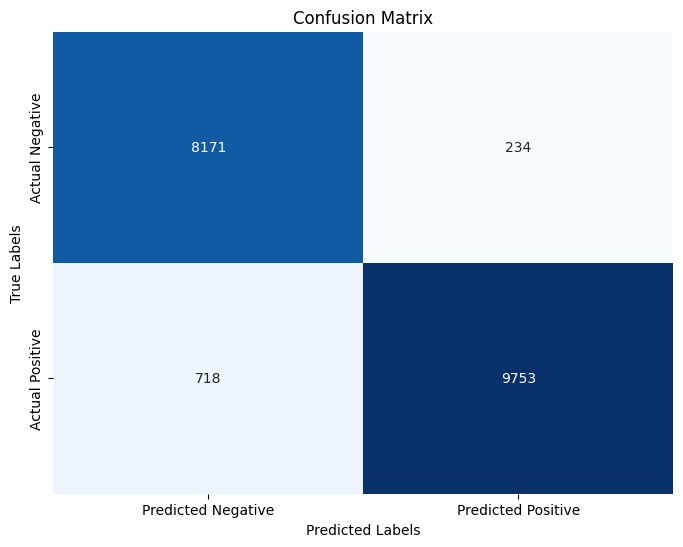

Elapsed time: 7:07:04.415669


In [ ]:
# Wrap the model using KerasClassifier
ann_classifier = KerasClassifier(build_fn=create_model, verbose=0)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__optimizer': [
        'adam',
        'rmsprop',
        'sgd'
    ],
    'model__init': [
        'uniform',
        'normal',
        'glorot_uniform'
    ],
    'model__layers': [
        1,
        2,
        3
    ],
    'model__first_layer_neurons': [
        16,
        32,
        64,
        128
    ],
    'model__input_dimen': [
        X_train.shape[1]
    ],
    'model__learning_rate': [
        0.001,
        0.01,
        0.1
    ],
    'epochs': [
        100,
        150
    ]
}

start_time = datetime.now()

# Setup the gridsearch with tuning using f1 due to imbalanced target classes
ann_grid = RandomizedSearchCV(estimator=ann_classifier, param_distributions=param_grid,
                              scoring='accuracy', cv=5, n_jobs=-1, random_state=42,
                              n_iter=60)

# train using the raw data without removing the outliers bc tree algos work fine with them
ann_grid = ann_grid.fit(X_train, y_train)

# print the best params
print(f'Best Parameters: {ann_grid.best_params_}')
print(f'Best accuracy: {ann_grid.best_score_}')

# Set the tuned_classifier to the best combination of parameters
ann_best_classifier = ann_grid.best_estimator_

# Calculate Predictions
y_pred = ann_best_classifier.predict(X_validation)

# Model Performance on the validation data
ann_best_report = model_performance_classification(ann_best_classifier, X_validation, y_validation, y_pred, 'ANN')

# Make predictions on the test data
y_test_pred = ann_best_classifier.predict(X_test_processed_df)

end_time = datetime.now()
print(f'Elapsed time: {end_time - start_time}')

# Output predictions into a csv
output = pd.DataFrame({'ID': test_data['ID'], 'Overall_Experience': y_test_pred})
output.to_csv('ann_predictions.csv', index=False)

#**Model Comparison and Summary**

In [ ]:
summary = pd.concat([rf_best_report, xgb_best_report, ann_best_report],axis=0, ignore_index=True)
summary

,name,precision,recall,f1-score,accuracy
0,Random Forest,0.96320,0.94977,0.95643,0.95200
1,XGBoost,0.96527,0.95559,0.96041,0.95629
2,ANN,0.97657,0.93143,0.95347,0.94957
